# Anomaly Detection for Marine Engine Performance Using Unsupervised Learning

**Author:** Matt Cocker  
**Date:** [March, 2025]  
**Project Type:** Anomaly Detection | Unsupervised ML | Operational Risk Analytics

---

## About this Notebook

This notebook explores how unsupervised machine learning methods can be used to detect anomalies in ship engine performance data. The objective is to identify early signs of mechanical issues that could lead to costly downtime or safety hazards.

Using six continuous engine monitoring features, this analysis applies techniques such as Isolation Forest and statistical thresholding to flag unusual behaviour and highlight components that may require proactive maintenance.

**Key Tasks:**
- Load and explore real-world engine monitoring data
- Apply preprocessing and scaling techniques
- Train anomaly detection models
- Evaluate model output and generate actionable business insights

# Imports

In [ ]:
# Step 1: Import the required libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# Data Preprocessing

In [ ]:
# URL to import data set from GitHub.
# url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'

# Step 2: Import the data set from Github
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'
engines = pd.read_csv(url)

# Step 3: View metadata

engines.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


In [ ]:
# Step 4: Confirm no duplicate values
engines.duplicated().any()

np.False_

As we can see, there are no duplicate values in the data.

In [ ]:
# Step 5: Confirm no missing values
engines.isna().any()


,0
Engine rpm,False
Lub oil pressure,False
Fuel pressure,False
Coolant pressure,False
lub oil temp,False
Coolant temp,False


As we can see, there are no missing values in the data.

# Exploratory Data Analysis

In [ ]:
# Step 6: Summarise the data, including median, 95th percentile and IQR

pd.concat([engines.describe(),
        pd.DataFrame(engines.median(), columns=['median']).T,
        pd.DataFrame(engines.quantile(0.05)).T,
        pd.DataFrame(engines.quantile(0.95)).T,
        pd.DataFrame((engines.quantile(0.75)-engines.quantile(0.25)), columns=['IQR']).T])


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912
median,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662
0.05,443.000000,1.941852,3.127162,1.084493,74.269140,68.401196


A cursory look at the data, in particular the difference in distance of the max and min from the mean, would suggest that the data in each column is not normally distributed.

By comparing where the 5th percentile of the data and the 95th percentile of the data are, we can clearly see that most columns show evidence of having a skewed distribution, where there are more values above the mean than below.

As such, in order to be able to visualise the data together, it will be normalised rather than standardised.

*The data is only being normalised to allow it to be visualised on the same set of axes. The normalised data will not be used beyond this until specifically stated*

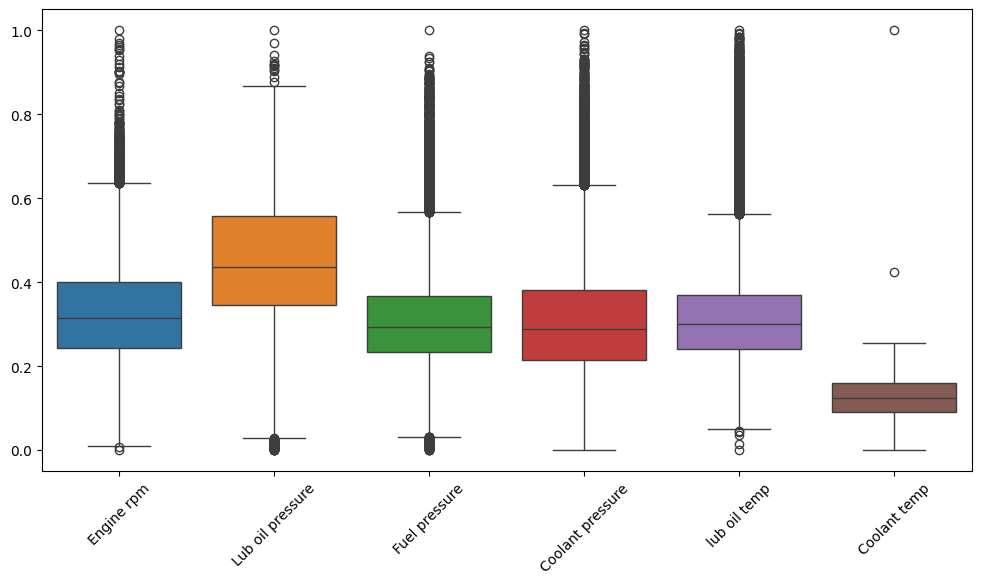

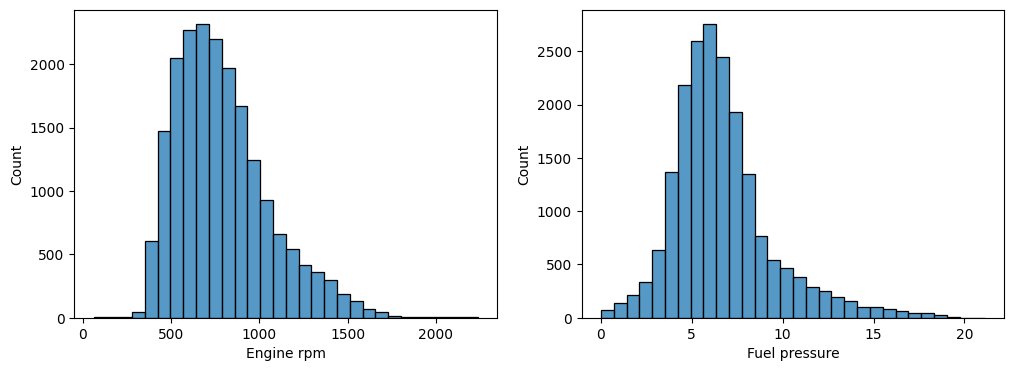

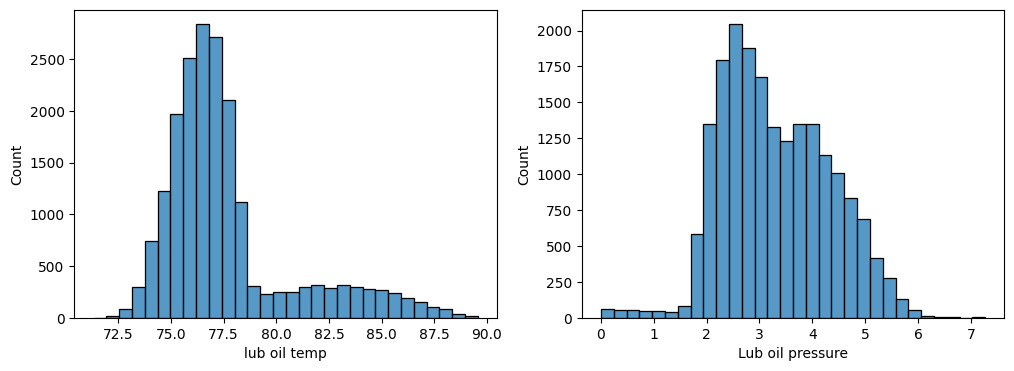

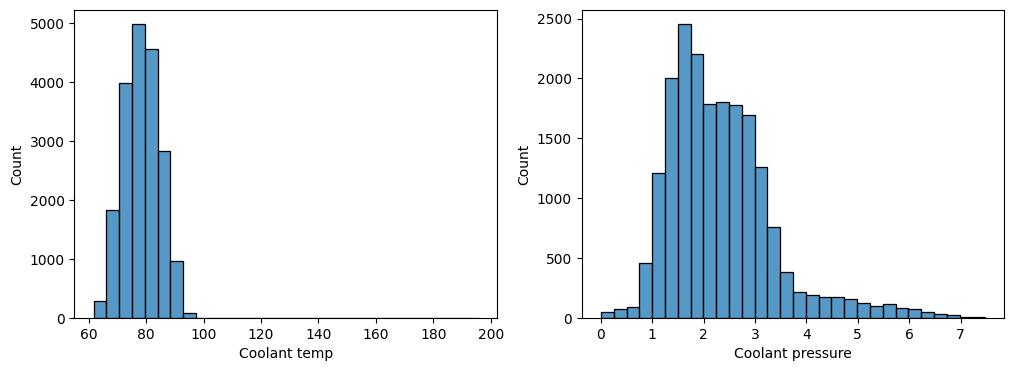

In [ ]:
# Step 5: Normalise the data

min_max_scaler = preprocessing.MinMaxScaler()
engines_normalised = min_max_scaler.fit_transform(engines)

engines_normalised = pd.DataFrame(engines_normalised, columns=engines.columns)

# Step 6: Visualise the data

plt.figure(figsize=(12,6))

sns.boxplot(data=engines_normalised)
plt.xticks(rotation=45)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data=engines["Engine rpm"], bins=30)

plt.subplot(1,2,2)
sns.histplot(data=engines["Fuel pressure"], bins=30)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data=engines["lub oil temp"], bins=30)

plt.subplot(1,2,2)
sns.histplot(data=engines["Lub oil pressure"], bins=30)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data=engines["Coolant temp"], bins=30)

plt.subplot(1,2,2)
sns.histplot(data=engines["Coolant pressure"], bins=30)

plt.show()



We can see from the box plot that there are fewer outliers for Coolant Temperature and Lubricant Oil Pressure than there are for the other data.

We can also see from the histograms that Engine RPM and Fuel Pressure follow a similar distribution, that Coolant Pressure and Lubricant Oil Temperature follow a similar distribution and that Coolant Temp may follow a normal distribution.

# Detecting Anomalies with IQR

In [ ]:
# Step 7: Calculate the quartiles and IQR

q1 = engines.quantile(0.25)
q3 = engines.quantile(0.75)
iqr = q3 - q1

# Step 8: Calculate the lower and upper limits

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Step 9: Create a DataFrame showing outliers

anomalies = engines[(engines > upper) | (engines < lower)]

anomalies["Count"] = anomalies.count(axis=1)

anomalies.sort_values(by="Count", ascending=False, inplace=True)

anomalies.head(350)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Count
5429,NaN,NaN,14.968655,4.994738,81.682039,NaN,3
685,1470.0,NaN,NaN,4.786933,87.439237,NaN,3
10111,NaN,NaN,12.687559,4.749380,82.738746,NaN,3
6254,NaN,NaN,13.686792,5.063884,85.377813,NaN,3
11395,1454.0,NaN,NaN,5.087253,88.609946,NaN,3
...,...,...,...,...,...,...,...
9807,1608.0,NaN,NaN,4.785381,NaN,NaN,2
7030,NaN,6.560669,NaN,5.066999,NaN,NaN,2
12420,1612.0,NaN,NaN,NaN,83.558226,NaN,2
2105,NaN,NaN,NaN,5.552353,83.764752,NaN,2


Outlier datapoints are kept as their values to preserve the exact information that makes them outliers. With the data kept as such, the domain expert (in this case an engineer) can use the information that is preserved to isolate potential causes of outliers.

We can see that the fewest outliers are caused by Lubricant Oil Pressure and Coolant Temperature, with Engine RPM also not causing a large proportion of outliers. A significant proportion of outliers are caused by Lubricant Oil Temperature; this could either be a common error in these particular engines or could be a common indicator of engine trouble.

In [ ]:
# Step 10: Count up how many times each number of outliers in a sample occurs

anomalies["Count"].value_counts()

,count
Count,
0,14899
1,4214
2,411
3,11


There are 19,535 samples in the dataset. If we assume that the total percentage of outliers should fall in the 1% to 5% range, we are looking for between 195.35 and 976.75 outliers.

There are 11 samples containing 3 outliers, and 411 samples containing 2 outliers, making a total of 422 samples containing 2 or more outliers. 422 falls within the 1% to 5% range (2.16%), therefore defining a sample as an outlier if it contains 2 or more outliers fits with our expected proportion of outliers in the data.

# Detecting Anomalies with One Class SVM

In [ ]:
# Step 11: Create a One Class SVM model for anomaly detection
# Here we use the normalised data from Step 5.

svm_model = OneClassSVM(kernel='rbf', gamma=0.75, nu=0.03)
svm_model.fit(engines_normalised)


OneClassSVM(gamma=0.75, nu=0.03)

This was first tested with gamma at 0.5 and nu at 0.05. This yielded 975 anomalies, which is within our 1% to 5% range.

However, in order to ensure understanding of the dataset, I investigated how changing the parameters interacts with the number of anomalies.

Reducing nu to 0.03 and leaving gamma at 0.5 gave an output of 587 anomalies (roughly 3%). The next step was to investigate how changing gamma interacted with the number of anomalies.

Increasing gamma to 0.75 and keeping nu at 0.03 also yielded 587 anomalies. In fact, increasing gamma to 0.95 and keeping nu at 0.03 still yielded 584 anomalies, suggesting that nu has a significantly greater impact on the number of anomalies outputted compared to gamma.

I settled on a gamma of 0.75 and a nu of 0.03 to ensure the model accurately reflected the shape of the distribution of anomalies, but reduced the risk of overfitting.

In [ ]:
# Step 12: Predict the classification of each datapoint as normal (1) or anomaly (-1)

engines_pred_svm = svm_model.predict(engines_normalised)
print(engines_pred_svm)

# Step 13: Create DataFrame for easy understanding

engines_svm = pd.DataFrame(engines_normalised)
engines_svm['anomaly'] = engines_pred_svm

engines_svm


[ 1 -1 -1 ...  1  1  1]


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,0.285124,0.328864,0.218310,0.380751,0.271126,0.061345,1
1,0.249770,0.752321,0.303815,0.765787,0.104098,0.098868,-1
2,0.274105,0.472427,0.174009,0.224214,0.918347,0.127239,-1
3,0.315886,0.287968,0.336773,0.218992,0.347210,0.154745,1
4,0.282369,0.486747,0.281677,0.431092,0.213835,0.040939,1
...,...,...,...,...,...,...,...
19530,0.284665,0.495086,0.345286,0.144583,0.267541,0.061077,1
19531,0.238292,0.308400,0.247895,0.196477,0.304671,0.189943,1
19532,0.254821,0.455327,0.179062,0.802372,0.250171,0.078792,1
19533,0.505969,0.375692,0.175083,0.394488,0.299179,0.147375,1


In [ ]:
# Step 14: Create a DataFrame showing outliers

engines_svm_anomalies = engines_svm[engines_svm.anomaly == -1]

engines_svm_anomalies


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,0.249770,0.752321,0.303815,0.765787,0.104098,0.098868,-1
2,0.274105,0.472427,0.174009,0.224214,0.918347,0.127239,-1
9,0.342057,0.543019,1.000000,0.210016,0.197239,0.077990,-1
17,0.574380,0.820698,0.357717,0.793132,0.351441,0.201627,-1
52,0.258953,0.773185,0.292669,0.151266,0.155517,0.113248,-1
...,...,...,...,...,...,...,...
19281,0.389807,0.809145,0.492030,0.840754,0.242841,0.052857,-1
19370,0.311754,0.384068,0.537297,0.211036,0.956793,0.062563,-1
19375,0.430670,0.016975,0.241453,0.526452,0.182015,0.229207,-1
19409,0.272727,0.558394,0.246683,0.250161,0.969803,0.125577,-1


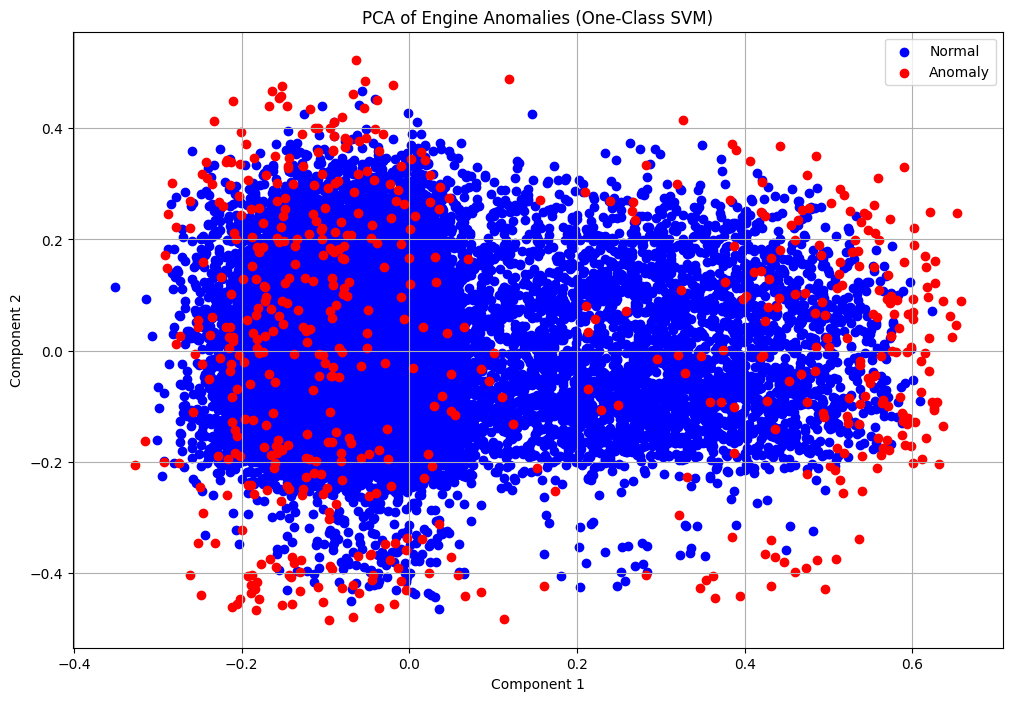

In [ ]:
# Step 15: Apply PCA to reduce the dimensions (using the normalised data from Step 5)

pca = PCA(n_components=2)
engines_pca = pca.fit_transform(engines_normalised)

# Step 16: Visualise the reduced data in 2D, colouring normal points blue and anomalies red.

plt.figure(figsize=(12, 8))

plt.scatter(engines_pca[engines_pred_svm == 1, 0],
            engines_pca[engines_pred_svm == 1, 1],
            color='blue',
            label='Normal')

plt.scatter(engines_pca[engines_pred_svm == -1, 0],
            engines_pca[engines_pred_svm == -1, 1],
            color='red',
            label='Anomaly')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('PCA of Engine Anomalies (One-Class SVM)')
plt.grid(True)
plt.show()


This scatter plot is somewhat uninterpretable - the anomalies seem to be mostly concentrated in two clusters, one where Component 1 is -0.15 and one where Component 1 is 0.55 but those clusters are not particularly tight. Moreover, as it is impossible to tell what goes into Component 1, this plot has limited practical use.

The next logical step is to try a different method of finding anomalies to see if that yields clearer results.

# Detecting Anomalies with Isolation Forest

In [ ]:
# Step 17: Create an Isolation Forest model for anomaly detection

iso = IsolationForest(contamination=0.03)
iso.fit(engines)

IsolationForest(contamination=0.03)

The contamination is set to 0.03 to identify 3% of the dataset as anomalies. This allows the output to be directly compared to that of One Class SVM.

In [ ]:
# Step 18: Predict the classification of each datapoint as normal (1) or anomaly (-1)

engines_pred_iso = iso.predict(engines)
print(engines_pred_iso)

# Step 19: Create DataFrame for easy understanding

engines_iso = pd.DataFrame(engines)
engines_iso['anomaly'] = engines_pred_iso

engines_iso


[ 1 -1  1 ...  1  1  1]


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,1
...,...,...,...,...,...,...,...
19530,681,3.598792,7.300853,1.083391,76.206955,69.848780,1
19531,580,2.243040,5.242489,1.471350,76.884907,87.098119,1
19532,616,3.310048,3.787693,6.001031,75.889810,72.220009,1
19533,1163,2.731726,3.703595,2.951684,76.784626,81.400088,1


In [ ]:
# Step 20: Create a DataFrame showing outliers

engines_iso_anomalies = engines_iso[engines_iso.anomaly == -1]

engines_iso_anomalies

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
7,576,5.495972,13.114658,1.251058,78.091390,71.934674,-1
9,806,3.946885,21.138326,1.572569,74.923316,72.112692,-1
17,1312,5.963439,7.563578,5.931953,77.738876,88.661972,-1
144,1762,1.697487,4.327845,2.523372,86.750349,82.393211,-1
...,...,...,...,...,...,...,...
19328,771,3.916701,5.136610,5.592643,85.757119,69.278462,-1
19334,1084,4.426314,11.785500,2.959202,87.426879,79.655316,-1
19375,999,0.126660,5.106325,3.938253,74.645346,92.353698,-1
19433,986,2.929212,14.431486,4.985264,75.477519,69.808798,-1


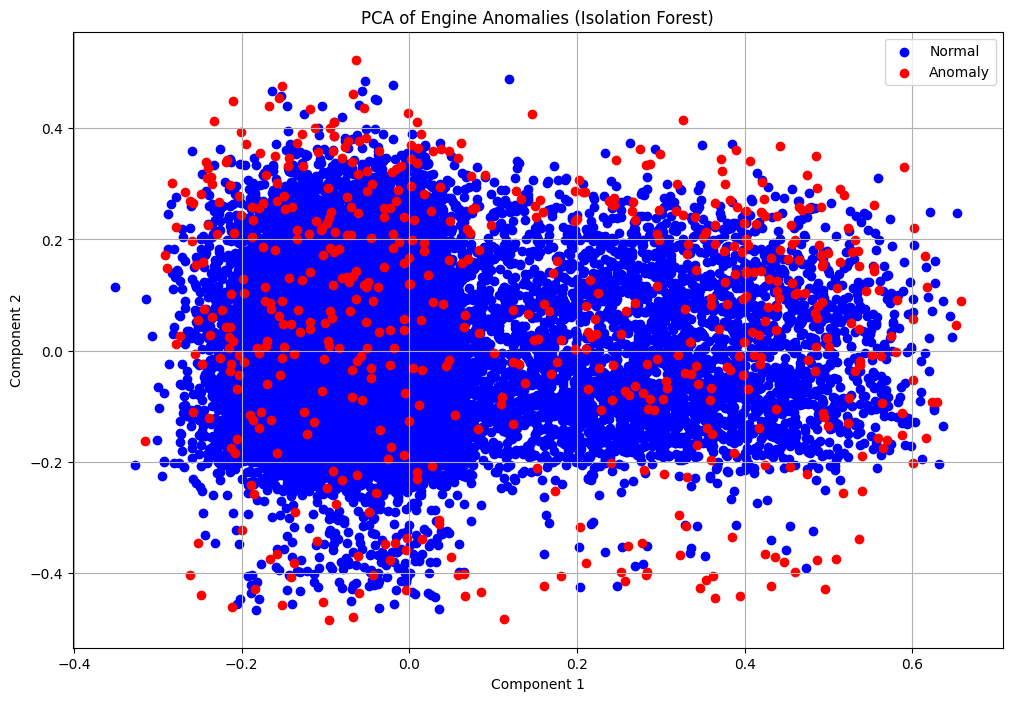

In [ ]:
# Step 21: Visualise the reduced data in 2D, colouring normal points blue and anomalies red (using the PCA data from Step 15)

plt.figure(figsize=(12, 8))

plt.scatter(engines_pca[engines_pred_iso == 1, 0],
            engines_pca[engines_pred_iso == 1, 1],
            color='blue',
            label='Normal')

plt.scatter(engines_pca[engines_pred_iso == -1, 0],
            engines_pca[engines_pred_iso == -1, 1],
            color='red',
            label='Anomaly')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('PCA of Engine Anomalies (Isolation Forest)')
plt.grid(True)
plt.show()


This scatter plot is also somewhat uninterpretable - there are no distinct clusters at all.

# Conclusions

In [ ]:
# Step 22: Compare the two methods.

engines_comp = pd.DataFrame(engines_normalised)
engines_comp['anomaly_svm'] = engines_pred_svm
engines_comp['anomaly_iso'] = engines_pred_iso
engines_comp['anomaly_tot'] = engines_pred_iso + engines_pred_svm

# Count the number of times -2 appears in 'anomaly tot'

engines_comp['anomaly_tot'].value_counts()


,count
anomaly_tot,
2,18644
0,608
-2,283


There are 293 samples which both ML models class as anomalies. This suggests that, whilst there is significant overlap, care must be taken when choosing which model to use, as the models class anomalies differently.

The IQR method is not appropriate for an anomaly detection system, as it is designed for individual features rather than a set of features which interact with each other. As such, one of the unsupervised learning models is a better solution.

In theory, one could use the overlap of both models to attempt to ensure there are no false positives. However, this would use up far more computing power than just one. As such, having done further research, I have concluded that Isolation Forest is the better model for the anomaly detection system.

Next steps would involve potentially using tSNE as a method of dimensionality reduction rather than PCA to potentially generate a scatter plot that has clearer clusters, as tSNE is better for visualisation than PCA.

Clustering methods could be applied to the anomalies to potentially identify different classes of anomalies which may have different causes - this would make it easier for engineers to diagnose engine problems, increasing operational efficiency.

### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]